# Hands-On in Reinforcement Learning in Python
In this notebook we will implement a some Reinforcement algorithm (Q-Learning, Deep Q-Network (DQN), REINFORCE)  to solve the different environments from OpenAI Gym.
In doing this, we will learn the basics of the Gym library, how to implement a QL, DQN, and REINFORCE agent, and how to train it.
This notebook is based on the following resources:
- [Deep Reinforcement Learning Hands-On](https://www.amazon.com/Deep-Reinforcement-Learning-Hands-Q-networks/dp/1788834240)
- [Torch Implementation](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

Finally, we will compare our implementation with the Stable Baselines 3 implementation.

## Requirements and Imports
First we need to install the requirements for this notebook.
We will use the following libraries:
- Gymnasium: Gymnasium is a collection of environments for OpenAI Gym.
- PyTorch: PyTorch is a deep learning framework, it is the most popular framework for deep learning research.
- Stable Baselines 3: Stable Baselines 3 is a library that implements several reinforcement learning algorithms.
- Virtualdisplay: Virtualdisplay is a library that allows us to render the environment in a headless server (i.e., in jupyter)
- Matplotlib: Matplotlib is a plotting library for python.

Deep Reinforcement Learning Libraries

In [1]:
!pip install swig==4.1.1 > /dev/null 2>&1
!pip install box2d-py==2.3.5 > /dev/null 2>&1
!pip install numpy=y=1.21.5 > /dev/null 2>&1
!pip install 'stable-baselines3>=2.0.0a9' > /dev/null 2>&1
!pip install 'gymnasium==0.28.1' > /dev/null 2>&1
!pip install 'gymnasium[box2d]==0.28.1' > /dev/null 2>&1
!pip3 install torch torchvision torchaudio > /dev/null 2>&1
!pip3 install 'protobuf==3.20.*' > /dev/null 2>&1

Visualization Libraries, NB! This works only on Linux! If you have problem in running this, you can upload this notebook to Google Colab and run it there.

In [2]:
!apt-get install -y xvfb x11-utils > /dev/null 2>&1
!pip install matplotlib > /dev/null 2>&1
!pip install xvfbwrapper > /dev/null 2>&1
!pip install 'pyvirtualdisplay==0.2.*'  'PyOpenGL==3.1.*' 'PyOpenGL-accelerate==3.1.*' > /dev/null 2>&1

For the sake of simplicity, we import all the libraries we will use in this notebook here.

In [3]:
# For protobuffer
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
## For environments
import gymnasium as gym
### From rendering
from IPython import display
import pyvirtualdisplay
### For the agent and training
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distributions
from torch.distributions import Categorical
import copy
## For replay buffer
from random import random
from random import sample
from collections import deque
# Plotting
import matplotlib.pyplot as plt
# Reproducibility
from random import seed
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
# for Q-Learning
import numpy as np
# for rendering purposes
import time
# pandas
import pandas as pd

/home/gianluca/.local/lib/python3.9/site-packages/ale_py/roms/__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()


## Gymnasium
Gymnasium is a collection of environments for OpenAI Gym.
The **goal** of Gymnasium is to provide a collection of environments that are easy to **use** and easy to **install**.

Moreover, Gymnasium provides a collection of **wrappers** that can be used to modify the behavior of the environments.
Finally, it is possible to create new environments by combining existing ones or by creating new ones from scratch.

Firstly, we need to create a virtual display to render the environment in the notebook

In [4]:
pyvirtualdisplay.Display(visible=False, size=(1400, 900)).start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

## Gym Basic
The typical usage of Gym is the following:
1. Create the environment: `env = gym.make("EnvName")`
2. Reset the environment: `env.reset()`
3. Iterate unless the environment is done:
    1. Pick an action: `action = ???`
    2. Progress the environment: `env.step(action)`


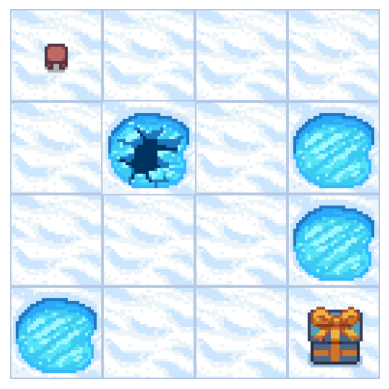

In [5]:
def visualize_environment(env, sleep=0, length=10):
    env.reset() ## When the env is created it should be reset to initialize the state
    img = plt.imshow(env.render()) ## Used for rendering purposes
    print(env.action_space.sample()) ## Action space is the set of actions that are possible in a given environment
    for i in range(length): ## Run for 100 steps
        env.step(env.action_space.sample()) ## Pick a random action and progress the environment
        img.set_data(env.render())
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(sleep)
## Create environment
env = gym.make('FrozenLake-v1', desc=None, render_mode="rgb_array", is_slippery=False)
visualize_environment(env, 1)

## Frozen Lake
The Frozen Lake environment is a 4x4 grid where the goal is to reach the **goal state** (G) from the **start state** (S).

It is an *episodic* environment, meaning that the episode ends when the agent reaches the goal or falls in a hole (H).
By default, the agent starts in the (0,0) position. The ground is *slippery*, meaning that the agent will not always move in the direction it chooses. 
It this case, we decide to remove the slippery ground since we use simple Q-Learning.

### Action Space

The action space is discrete and has 4 possible actions:
- Left
- Down
- Right
- Up

### Observation space
The observation space is discrete and has 16 possible states, one for each position in the grid.

**NB**: the hole are considered fixed, meaning that they are always in the same position.

### Reward 
+1 if the agent reaches the goal state, 0 otherwise

## Q-Learning
Q-Learning is a model-free reinforcement learning algorithm that learns the value of an action in a particular state.

The Q-value can be represented as a table where each row represents a state and each column represents an action.

Particularly, using **numpy**, we can represent the Q-table as a matrix of size `num_states` x `num_actions`.

In [6]:
Q = np.zeros((env.observation_space.n, env.action_space.n)) ## we can initialize the matrix with 0 or random number
Q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

### Learning phase
The learning phase is composed of the following steps:
1. Initialize the Q-table with zeros
2. Observe the current state
3. Choose an action using an epsilon-greedy policy
4. Take the action and observe the next state and reward
5. Update the Q-table using the Bellman equation
6. Repeat from step 2 until the episode is done
7. Repeat from step 2 until the total number of episodes is reached

The Bellman equation is the following:
$$Q(s,a) = Q(s,a) + \alpha \cdot (r + \gamma \cdot \max_{a'} Q(s',a') - Q(s,a))$$


In [7]:
def q_learning(environment, num_episodes, learning_rate=0.5, discount_factor=0.9, exploration_prob=1.0, epsilon_decay=0.999):
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    # Initialize Q-table with zeros
    Q = np.zeros((num_states, num_actions))

    rewards_per_episode = [] ## For plotting purposes

    for episode in range(num_episodes): ## Iterate over episodes
        state, _ = environment.reset() ## For each episode, reset the environment and get the initial state
        done = False ## Flag to check if the episode is done
        episode_reward = 0 ## Record the total reward of the episode

        while not done:
            # Choose action using epsilon-greedy policy
            if np.random.rand() < exploration_prob:
                action = environment.action_space.sample()
            else:
                action = np.argmax(Q[state])

            # Take the action and observe the next state and reward
            next_state, reward, done, _, _ = environment.step(action)

            # Update Q-value using the Q-learning update rule
            best_next_action = np.max(Q[next_state])

            # The Q-learning update rule
            bellman_update = reward + discount_factor * best_next_action - Q[state, action]

            Q[state, action] = Q[state, action] + learning_rate * bellman_update

            episode_reward += reward
            state = next_state ## Prepare for the next iteration, updating the current state

        rewards_per_episode.append(episode_reward)
        # Decay exploration probability
        exploration_prob *= epsilon_decay
    return Q, rewards_per_episode

### Evaluation phase

In the evaluation phase, we use the learned Q-table to choose the best action in each state.

Therefore, we do not need to explore anymore, so we set the exploration probability to 0 (i.e., we always choose the best action, greedy policy).

The evaluation steps are the same as the learning steps, except for the update of the Q-table.

In [8]:
def evaluate_agent(env, q_table, num_episodes=100, render=False):
    total_rewards = [] ## For plotting purposes, total reward for each episode

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0

        while not done:
            # Choose the best action according to the learned Q-values
            action = np.argmax(q_table[state])
            # Take the action and observe the next state and reward
            next_state, reward, done, _, _ = env.step(action)

            episode_reward += reward
            state = next_state
            # Rendering the environment for visualization (if render is set to True)
            if render:
                plt.imshow(env.render())
                plt.axis('off')
                display.display(plt.gcf())
                display.clear_output(wait=True)

        total_rewards.append(episode_reward)
    return total_rewards

In the following, some useful functions to plot the results.

In [9]:
'''
Simple function to plot the rewards per episode
:param rewards: the rewards per episode (i.e., a list of rewards)
'''
def plot_rewards(rewards, ax=plt):
    ax.plot(rewards)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Total Reward")

def render_q_table(q, ax=plt):
    ax.imshow(q, cmap='summer', interpolation='nearest')

def render_v_table_from_q(q, x, y, ax=plt):
    v = np.max(q, axis=1)
    ax.imshow(v.reshape(x,y), cmap='summer', interpolation='nearest')

def render_v_table_3d_from_q(q, x, y, ax):
    v = np.max(q, axis=1)
    X = np.arange(0, x, 1)
    Y = np.arange(0, y, 1)
    X, Y = np.meshgrid(X, Y)
    ax.plot_surface(X, Y, v.reshape(y,x), cmap='summer', linewidth=0, antialiased=False)

def statistics(rewards):
    avg_reward = np.mean(rewards)
    max_reward = np.max(rewards)
    min_reward = np.min(rewards)

    print(f"Average reward over {len(rewards)} episodes: {avg_reward}")
    print(f"Max reward: {max_reward}")
    print(f"Min reward: {min_reward}")

### Train and evaluate the agent
Here we train the agent for 1000 episodes and then evaluate it for 100 episodes.


In [ ]:
num_episodes = 3000
q_table, rewards_per_episode = q_learning(env, num_episodes=num_episodes)

# Evaluate the agent
num_evaluation_episodes = 100
evaluation_rewards = evaluate_agent(env, q_table, num_episodes=num_evaluation_episodes, render=False)

In [10]:
'''
Simple function to plot the rewards per episode
:param rewards: the rewards per episode (i.e., a list of rewards)
'''
def plot_rewards(rewards, ax=plt, window_size=10):
    ## average with a window of 10 sample
    rewards = np.convolve(rewards, np.ones(window_size), 'valid') / window_size
    ax.plot(rewards)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Total Reward")

def render_q_table(q, ax=plt):
    ax.imshow(q, cmap='summer', interpolation='nearest')

def render_v_table_from_q(q, x, y, ax=plt):
    v = np.max(q, axis=1)
    ax.imshow(v.reshape(x,y), cmap='summer', interpolation='nearest')

def render_v_table_3d_from_q(q, x, y, ax):
    v = np.max(q, axis=1)
    X = np.arange(0, x, 1)
    Y = np.arange(0, y, 1)
    X, Y = np.meshgrid(X, Y)
    ax.plot_surface(X, Y, v.reshape(y,x), cmap='summer', linewidth=0, antialiased=False)

def statistics(rewards):
    avg_reward = np.mean(rewards)
    max_reward = np.max(rewards)
    min_reward = np.min(rewards)

    print(f"Average reward over {len(rewards)} episodes: {avg_reward}")
    print(f"Max reward: {max_reward}")
    print(f"Min reward: {min_reward}")

In [11]:
def experiment_analysis(evaluation_rewards, rewards_per_episode, q_table, size=(4, 4)):
    x, y = size
    # Plot rewards during training and evaluation
    statistics(evaluation_rewards)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plot_rewards(rewards_per_episode, axs[0])
    plot_rewards(evaluation_rewards, axs[1])
    plt.show()
    ## Plot the three chart in one line
    fig = plt.figure()
    ax = fig.add_subplot(221)
    render_q_table(q_table, ax)
    ax = fig.add_subplot(222)
    render_v_table_from_q(q_table, x, y, ax)
    ax = fig.add_subplot(212, projection='3d')
    render_v_table_3d_from_q(q_table, x, y, ax)
    plt.show()

In [ ]:
experiment_analysis(evaluation_rewards, rewards_per_episode, q_table)

In [ ]:
evaluation_rewards = evaluate_agent(env, q_table, num_episodes=5, render=True)

## Can you use it in other environments?
Sure! You can use the Q-learning algorithm in any environment that has a discrete action space and a discrete observation space.
For instance, we can train it in CliffWalking environment.

In [ ]:
env = gym.make('CliffWalking-v0', render_mode="rgb_array")
num_episodes = 1000
q_table, rewards_per_episode = q_learning(env, num_episodes=num_episodes)

# Evaluate the agent
num_evaluation_episodes = 100
evaluation_rewards = evaluate_agent(env, q_table, num_episodes=num_evaluation_episodes, render=False)
experiment_analysis(evaluation_rewards, rewards_per_episode, q_table, size=(4, 12))

In [ ]:
evaluation_rewards = evaluate_agent(env, q_table, num_episodes=5, render=True)

## Deep Q Learning
Deep Q Learning is a reinforcement learning algorithm that uses a neural network to approximate the Q function.
Here we will implement the Deep Q Learning algorithm using PyTorch.
Firstly, we need to select the device we will use for training.

In [12]:
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

For reproducibility, we set the seed of the random number generators.
This is really import to make the results comparable.

In [13]:
torch.manual_seed(42)
seed(42)

## Environment: Lunar Lander
The Lunar Lander environment is a 2D environment where the goal is to land the lander on the landing pad.

The episode ends when the lander crashes or comes to rest.
The environment is considered solved when the agent gets an average reward of 200 over 100 consecutive episodes.

### Action Space

The action space is discrete and has 4 possible actions:
- Left
- Down
- Right
- Up

### Observation space
The observation space is continuous and has 8 dimensions:
- x position
- y position
- x velocity
- y velocity
- angle
- angular velocity
- left leg contact (bool)
- right leg contact (bool)

### Reward
The reward is given as follows:
- +100 for landing on the landing pad
- -100 for landing outside the landing pad
- -0.3 for using the main engine
- -0.03 for using the side engines
- +10 for landing on the landing pad with the legs touching the ground

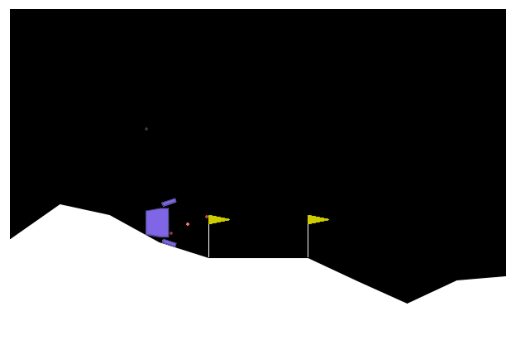

In [14]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")
visualize_environment(env, 0, 100)

### Replay Buffer
The replay buffer is used to store the experiences of the agent.
An **experience** is a tuple of the form (state, action, reward, next_state, done).
From this set of experiences, the agent will sample a batch of experiences to train the neural network.

In [19]:
## Factory function to create an experience
def create_experience(state, action: int, reward: float, next_state, done: bool):
    return {
        "state" : state, "action" : action, "reward" : reward, "next_state" : next_state, "done" : done
    }

## Replay buffer, it is a deque with a maximum length
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(create_experience(*args))

    def sample(self, batch_size):
        return sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


### Network
The network is a simple feed-forward neural network with 2 hidden layers.
The input of the network is the state and the output is the Q value for each action.
It is also possible to use a convolutional neural network as input.
In torch, the network is a subclass of `nn.Module`.
Another solution is to use the `nn.Sequential` class (similar to Keras).

In [20]:
class DQN(nn.Module):
    def __init__(self, n_observations: int, n_actions: int, hidden_size: int):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Exponential Decay
The epsilon value is used to control the exploration of the agent.
At the beginning of the training, the agent should explore the environment.
As the training progresses, the agent should explore less and less.
The epsilon value is used to control this exploration.
The epsilon value is decayed after each episode following an exponential decay --- a typical solution in RL.
A standard initial value for epsilon is 1 and a standard final value is 0.01.

In [21]:
# Exponential decay that decays from start to end. After each call to decay it should reduce the value by decay_rate
class ExponentialDecay:
    def __init__(self, start: float, end: float, decay_rate: float):
        self.start = start
        self.end = end
        self.decay_rate = decay_rate
        self.value = start
        self.initial = start
    def decay(self):
        self.value = max(self.end, self.value * self.decay_rate)

    def __call__(self):
        return self.value

    def reset(self):
        self.value = self.initial

### Learning Agent
The learning agent is the agent that will learn the Q function.
It uses the replay buffer and the neural network to learn the Q function.
It also needs:
- A batch size to sample from the replay buffer
- A discount factor gamma
- A learning rate for the neural network
- An epsilon value for the exploration
- The action space for randomly sampling actions

Internally, the agent has two neural networks:
- The policy network that is used to select actions
- The target network that is used to compute the target Q values

The target network is updated every `copy_target_every` steps.

As optimization algorithm, we use AdamW, but you can use any optimizer you want.

The agent can be in two modes:
- Learning mode: the agent is learning and the policy network is updated
- Evaluation mode: the agent is not learning and the policy network is not updated

The agent has key three methods:
- `record` to record an experience in the replay buffer and update the policy network (if it is in learning mode)
- `act` to select an action given a state (using the policy network)
- `act_eps_greedy` to select an action given a state (using the policy network) with epsilon greedy exploration (if it is in learning mode)

In [22]:
class DQNAgent:
    def __init__(
             self,
             network: nn.Module, # The neural network, it should inherit from nn.Module
             memory: ReplayMemory, # The replay buffer
             batch_size: int,
             gamma: float, # The discount factor
             learning_rate: float, # The learning rate
             epsilon: ExponentialDecay, # The epsilon value for exploration
             action_space: gym.spaces.Space, # The action space used to sample actions
             copy_target_every: int = 100
         ):
        self.policy_network = network
        self.target_network = copy.deepcopy(network)
        self.policy_network.train()
        self.target_network.train()
        self.memory = memory
        self.batch_size = batch_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=learning_rate, amsgrad=True)
        self.epsilon = epsilon
        self.copy_target_every = copy_target_every
        self.updates = 0
        self.action_space = action_space
        self.learning = True

    def eval(self):
        self.policy_network.eval()
        self.target_network.eval()
        self.learning = False

    def train(self):
        self.policy_network.train()
        self.target_network.train()
        self.learning = True

    def act(self, state):
        with torch.no_grad():
            return self.policy_network(state).max(0)[1].item()

    def act_epsilon_greedy(self, state):
        if not self.learning or random() > self.epsilon():
            return self.act(state)
        else:
            return self.action_space.sample()

    def record(self, state, action: int, reward: float, next_state, done: bool):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size and self.learning:
            self.learn()
            self.updates += 1
            if self.updates % self.copy_target_every == 0:
                self.target_network.load_state_dict(self.policy_network.state_dict())
    def learn(self):
        batch = self.memory.sample(self.batch_size)
        ## Create tensors for the batch
        states = torch.stack([experience["state"] for experience in batch]).to(device)
        actions = torch.tensor([experience["action"] for experience in batch]).to(device)
        rewards = torch.tensor([experience["reward"] for experience in batch]).to(device)
        next_states = torch.stack([experience["next_state"] for experience in batch]).to(device)
        dones = torch.tensor([experience["done"] for experience in batch])
        ## Compute the target
        with torch.no_grad(): ## No backprop here, just for the target (i.e. ground truth)
            next_state_values = self.target_network(next_states).max(1)[0]
        target = rewards + (self.gamma * next_state_values)  # $y_i = r + \gamma \max_{a'} Q(s', a', \theta^-)$
        target[dones] = rewards[dones] # If done, then $y_i = r$
        ## Compute the prediction
        predicted = self.policy_network(states).gather(1, actions.unsqueeze(1)).squeeze(1) # $Q(s, a, \theta)$
        criterion = nn.SmoothL1Loss()
        loss = criterion(predicted, target) # L = (y_i - Q(s, a, \theta))^2
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


### Rendering
We use matplotlib to render the environment with virtual display to render the environment.
The rendering can be disabled by using the OffRenderer class.
The rendering can be enabled by using the OnRenderer class.
The OnRenderer class can be configured to render every render_every steps.

In [23]:
class RenderStrategy:
    def render(self, data: list):
        pass
    def update(self):
        pass
class OffRenderer(RenderStrategy):
    def render(self, data: list):
        return

class OnRenderer(RenderStrategy):
    def __init__(self, render_every=1):
        self.img = None
        self.render_every = render_every
        self.render_count = 0
    def render(self, data: list):
        if self.render_count % self.render_every == 0:
            if self.img is None:
                self.img = plt.imshow(data)
            self.img.set_data(env.render())
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
    def update(self):
        self.render_count += 1
        self.img = None

### Episode runner
The run_episode function runs an episode of the environment.
It returns the total reward of the episode.
The run_episode function can be configured to render the environment using the render parameter.
The run_episode function can be configured to learn using the learning parameter.
The steps executed in the run_episode function are:
1. Reset the environment and get the initial state
2. Initialize the total reward to 0
3. Initialize the done flag to False
4. While the episode is not done:
    1. Render the environment
    2. Get the action from the agent
    3. Execute the action in the environment
    4. Record the experience in the agent (if in learning mode, the agent will also perform a learning step)
    5. Update the total reward
    6. Update the done flag

In [24]:
## Episode

def run_episode(env: gym.Env, agent: DQNAgent, render: RenderStrategy, learning: bool = True):
    if learning: agent.train()
    else: agent.eval()
    state = env.reset()[0]
    total_reward = 0
    done = False
    while not done:
        render.render(env.render()) ## Used for rendering purposes
        action = agent.act_epsilon_greedy(torch.tensor(state, dtype=torch.float32, device=device))
        next_state, reward, terminated, truncated, info = env.step(action)
        if learning:
            agent.record(torch.tensor(state, dtype=torch.float32, device=device), action, reward, torch.tensor(next_state, dtype=torch.float32, device=device), done)
        state = next_state
        done = terminated or truncated
        total_reward += reward
    return total_reward

### Training Loop
The train function trains the agent in the environment for a number of episodes.
The train function returns a list of rewards for each episode.
The train function can be configured to learn using the learning parameter.
The steps executed in the train function are:
1. For each episode:
    1. Run the episode
    2. Decay the epsilon
    3. Record the reward
    4. Print the episode number, reward and epsilon
    5. Plot the rewards
    6. Update the renderer

In [ ]:
def train(env: gym.Env, agent: DQNAgent, episodes: int, render: RenderStrategy):
    rewards = []
    for episode in range(episodes):
        display.clear_output(wait=True)
        reward = run_episode(env, agent, render)
        agent.epsilon.decay()
        rewards.append(reward)
        print(f"Episode: {episode}, Reward: {reward}, Epsilon {agent.epsilon()}")
        ## Plot the rewards
        plt.clf()
        plt.title(f'Training...  Episode: {episode}')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(rewards)
        display.display(plt.gcf())
        render.update()
        display.clear_output(wait=True)
    return rewards

### Training the agent in the environment
With all the pieces in place, we can now train the agent in the environment.
Firstly, we initialize the environment using the gym.make function.

Then, we initialize the agent.
We use the DQN network with 256 hidden units, a ReplayMemory with 10000 capacity, a batch size of 128, a discount factor of 0.99, a learning rate of 1e-4 and an epsilon decay of 0.99.
The learning is highly influenced by the hyperparameters, so feel free to experiment with them.

Finally, we train the agent for 1000 episodes.

In [ ]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")
## Initialize the networks
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n
hidden_size = 256
network = DQN(n_observations, n_actions, hidden_size).to(device)
memory = ReplayMemory(10000)
batch_size = 128
gamma = 0.99
learning_rate = 1e-4
epsilon = ExponentialDecay(0.9, 0.05, 0.99)
agent = DQNAgent(network, memory, batch_size, gamma, learning_rate, epsilon, env.action_space, 1000)

train(env, agent, 500, render=OnRenderer(100))
"Trained..."

### Evaluating the agent
We can evaluate the agent by running an episode in the environment.

In [ ]:
run_episode(env, agent, render=OnRenderer(1), learning=False)

### Is the approach general?
The approach we used to solve the Lunar Lander environment can be used to solve other environments as well.
We can use the same approach to solve the CartPole environment.
The only difference is the hyperparameters. Similarly of what we have done with Q-learning

CartPole contains 4 observations and 2 actions.
The observations are the position and velocity of the cart and the angle and angular velocity of the pole.
The actions are moving left or right.
The reward is 1 for every step taken, including the termination step.
The episode terminates when the pole is more than 15 degrees from vertical or the cart moves more than 2.4 units from the center.
The goal is to keep the pole upright

In [ ]:
torch.manual_seed(42)
from random import seed

seed(42)
env = gym.make('CartPole-v1', render_mode="rgb_array")
## Initialize the networks
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n
hidden_size = 128
network = DQN(n_observations, n_actions, hidden_size).to(device)
memory = ReplayMemory(10000)
batch_size = 512
gamma = 0.99
learning_rate = 0.0001
epsilon = ExponentialDecay(0.99, 0.01, 0.95)
agent = DQNAgent(network, memory, batch_size, gamma, learning_rate, epsilon, env.action_space, 20000)
train(env, agent, 301, render=OnRenderer(20))
"Trained..."


In [ ]:
run_episode(env, agent, render=OnRenderer(1), learning=False)

## Reinforce -- a policy gradient algorithm
REINFORCE algorithm is a policy gradient algorithm.
Deep Q Learning can work with discrete action space and deterministic policy.

There are environments that can be solved only with stochastic policy.
REINFORCE algorithm can be used to solve such environments (also the one with continous action space).

It is based on the policy gradient theorem, which states that the gradient of the expected reward is the expected reward of the gradient.

In [25]:
class BaseReinforce(nn.Module):
    def __init__(self):
        super(BaseReinforce, self).__init__()
        self.data = [] ## store the trajectory of a certain rollout (simulation)

    def put_data(self, item):
        self.data.append(item) ## append data that is a tuple (reward, action probability)

    def train_net(self):
        G = 0 ## return
        self.optimizer.zero_grad()
        for r, prob in self.data[::-1]: ## start from the last element, it starts to compute the return for each step
            G = r + self.gamma * G ## recursive formula, g_t = r + gamma * g_{t+1}
            loss = -torch.log(prob) * G ## compute the loss as the policy gradient states
            loss.backward() ## compute the gradients
        self.optimizer.step() ## perform the backprop at the end
        self.data = []

To create a discrete REIFORCE algorithm, we can leverage the softmax activation (that gives as output probabilities) and a categorical distribution to sample actions.


In [26]:
class ReinforceDiscretePolicy(BaseReinforce):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, learning_rate: float, gamma: float):
        super(ReinforceDiscretePolicy, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        distribution = Categorical(x)
        action = distribution.sample()
        return (action, x[action])

### Training
The training dynamics are similar to the one of Q-learning based algorithm. 
The main difference here is that it is a monte carlo rollout with an on-policy update.
Therefore, before uptading the policy, we need to perform a whole simulation.
This means that this **doens't** work for non-episodic tasks.

In [27]:
def reinforce_training(policy, env, episodes):
    score = 0.0
    print_interval = 20
    scores = []
    for episode in range(episodes):
        state, _ = env.reset()
        done = False

        while not done:
            (action, prob) = policy(torch.from_numpy(state).float())
            next_state, r, done, truncated, info = env.step(action.item())
            policy.put_data((r,prob))
            state = next_state
            score += r

        policy.train_net()

        ## print in the same line and erase the previous line
        if episode % print_interval == 0 and episode != 0:
            print("\rEpisode {}\tAverage Score: {:.2f}".format(episode, score/print_interval), end="")
            scores.append(score/print_interval)
            score = 0.0
    return scores

### Evaluation
Since this is an on policy, in the evaluation phase we can directly use the policy found.
The main difference is that we don't improve the policy anymore after the episode ends.

In [28]:
def eval_reinforce(policy, env, episodes, render:RenderStrategy = OnRenderer()):
    score = 0.0
    scores = []
    for episode in range(episodes):
        state, _ = env.reset()
        done = False

        while not done:
            render.render(env.render())
            (action, prob) = policy(torch.from_numpy(state).float())
            next_state, r, done, truncated, info = env.step(action.item())
            state = next_state
            score += r
        render.update()
        display.clear_output(wait=True)
    return scores

In [ ]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
policy = ReinforceDiscretePolicy(env.observation_space.shape[0], env.action_space.n, 128, 0.0002, 0.98)
rewards = reinforce_training(policy, env, 3000)

In [ ]:
statistics(rewards)
ax = plt.gca()
plot_rewards(rewards, ax)
plt.show()

In [ ]:
eval_reinforce(policy, env, 1, render=OnRenderer(1))

## Stable Baseline
It is a library that provides implementations of reinforcement learning algorithms. It is built on top of Tensorflow and PyTorch. It provides a common interface for all the algorithms and it is easy to use. It also provides a set of tools for training, saving and loading models that can be used for further training or evaluation.
Useful links:
- [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/)

Use stable baselines when:
- You want to use a pre-implemented algorithm
- You want to use a pre-implemented neural network architecture
- You want to use a pre-implemented training loop

In [ ]:
environment = "CartPole-v1"

In [ ]:
vec_env = make_vec_env(environment, n_envs=4) ## use 4 parallel environments (fast training)
model = PPO("MlpPolicy", vec_env, verbose=1) ## Use a multi-layer perceptron policy
model.learn(total_timesteps=100000) ## Train for 100k steps
model.save("ppo")
del model # remove to demonstrate saving and loading

In [ ]:
model = PPO.load("ppo")

env = gym.make(environment, render_mode="rgb_array")
obs, _ = env.reset()

img = plt.imshow(env.render()) ## Used for rendering purposes
done = False
while not done:
    action, _states = model.predict(torch.tensor(obs).unsqueeze(0))
    obs, rewards, end, truncated, _ = env.step(action[0])
    done = end or truncated
    img.set_data(env.render())
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)


## Model your own environment
In this case, we will model a stock trading environment. The environment will be a gym environment, so we will be able to use it with stable baselines (or the other algorithms that we implemented so far).

Firstly, we try to observe the data that we have (in GOOGL.csv)

### Data exploration
We use pandas to load the data and matplotlib to plot it.

In [29]:
google_stock = pd.read_csv("GOOGL.csv")
google_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602
...,...,...,...,...,...,...,...
4426,2022-03-18,2668.489990,2724.879883,2645.169922,2722.510010,2722.510010,2223100
4427,2022-03-21,2723.270020,2741.000000,2681.850098,2722.030029,2722.030029,1341600
4428,2022-03-22,2722.030029,2821.000000,2722.030029,2797.360107,2797.360107,1774800
4429,2022-03-23,2774.050049,2791.770020,2756.699951,2765.510010,2765.510010,1257700


<AxesSubplot: xlabel='Date'>

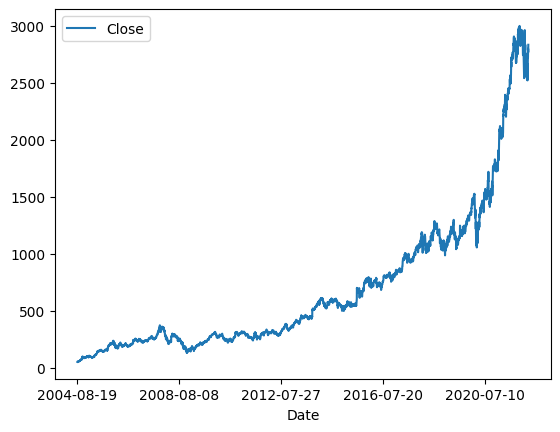

In [30]:
google_stock.plot(x="Date", y="Close")

We will use the Close column as the price of the stock to create the state.
To verify our approach, we divide the data into training and test set.

In [31]:
training_data = google_stock[google_stock["Date"] < "2014-01-01"]
test_data = google_stock[google_stock["Date"] >= "2014-01-01"]

### Modelling the environment
We will model the environment as a gym environment.
Therefore, we need to define the state, the action space and the reward function.

#### State
The state will be the current stock price and the current inventory.
Any other ideas??


#### Action space
The action space will be discrete, and it will be composed of 3 actions:
- Sell
- Hold
- Buy

#### Reward function
The reward function will be the profit that we make at the end of the episode.

In [36]:
class StockTradingEnv(gym.Env):
    def __init__(self, stock_data, start_cash=1000):
        super(StockTradingEnv, self).__init__()

        # Stock data should be a pandas DataFrame with 'Date' and 'Close' columns
        self.stock_data = stock_data
        self.n_days = len(stock_data)

        self.current_day = None ## start day (always from 0)
        self.start_cash = start_cash  # Starting cash for the agent
        self.current_cash = None ## Current cash that we have
        self.current_stock_price = None ## Current stock price
        self.current_inventory = None ## Number of stocks that we have

        self.action_space = gym.spaces.Discrete(3)  # Sell, Hold, Buy
        self.observation_space = gym.spaces.Box(
            low=0,
            high=np.inf,
            shape=(2,),  # Current stock price and current inventory
            dtype=np.float32
        )

    def reset(self, **kwargs):
        self.current_day = 0
        self.current_cash = self.start_cash
        self.current_stock_price = self.stock_data.iloc[self.current_day]['Close']
        self.current_inventory = 0

        return np.array([self.current_stock_price, self.current_inventory]), 0.0

    def step(self, action):
        assert self.action_space.contains(action)

        done = False
        reward = 0

        # Execute the action
        if action == 0:  # Sell
            if self.current_inventory > 0:
                self.current_cash += self.current_stock_price * self.current_inventory
                self.current_inventory = 0
        elif action == 2:  # Buy
            if self.current_cash > 0:
                max_can_buy = int(self.current_cash / self.current_stock_price)
                self.current_inventory += max_can_buy
                self.current_cash -= max_can_buy * self.current_stock_price

        # Move to the next day
        self.current_day += 1
        ## Simulation over, collect the reward
        if self.current_day >= self.n_days:
            done = True
            reward = self.current_cash + self.current_inventory * self.current_stock_price - self.start_cash
        else: ## update the state
            self.current_stock_price = self.stock_data.iloc[self.current_day]['Close']

        # Calculate the reward (simple buy-and-hold strategy)
        if self.current_day == self.n_days - 1:
            reward = self.current_cash + self.current_inventory * self.current_stock_price - self.start_cash

        return np.array([self.current_stock_price, self.current_inventory]), reward, done, False, {}

In [37]:
from stable_baselines3 import DQN as StableDQN
env = StockTradingEnv(training_data)
model = StableDQN("MlpPolicy", env, verbose=1) ## Use a multi-layer perceptron policy
model.learn(total_timesteps=100000) ## Train for 100k steps
model.save("dqn-trading")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.36e+03 |
|    ep_rew_mean      | 5.88e+03 |
|    exploration_rate | 0.104    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4972     |
|    time_elapsed     | 1        |
|    total_timesteps  | 9436     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.36e+03 |
|    ep_rew_mean      | 5.88e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4981     |
|    time_elapsed     | 3        |
|    total_timesteps  | 18872    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.36e+03 |
|    ep_rew_mean      | 6.61e+

In [39]:
def evaluate(env, times=10, policy=lambda obs: env.action_space.sample()):
    total_reward = 0
    for _ in range(times):
        obs, _ = env.reset()
        done = False
        while not done:
            action = policy(obs)
            obs, rewards, end, truncated, _ = env.step(action)
            done = end or truncated
            total_reward += rewards
    return total_reward / times

model = StableDQN.load("dqn-trading")
env = StockTradingEnv(test_data)
total_reward = evaluate(env, times=10, policy=lambda obs: model.predict(torch.tensor(obs).unsqueeze(0), deterministic=True)[0][0])
random_reward = evaluate(env, times=10, policy=lambda obs: env.action_space.sample())

print(total_reward)
print(random_reward)
print(total_reward / random_reward)


4548.64563
1507.7176088000003
3.0169082084411607
